In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

**Fase 1**

Datos cargados: (7109704, 51)
Muestra: (200000, 51)
         PERIODO ESTU_FECHANACIMIENTO  anio_nac  anio_exam  edad
5626973    20102           1991-06-11    1991.0     2010.0  19.0
2186974    20172                  NaT       NaN     2017.0   NaN
161583     20152                  NaT       NaN     2015.0   NaN
5229196    20132                  NaT       NaN     2013.0   NaN
6819489    20224                  NaT       NaN     2022.0   NaN


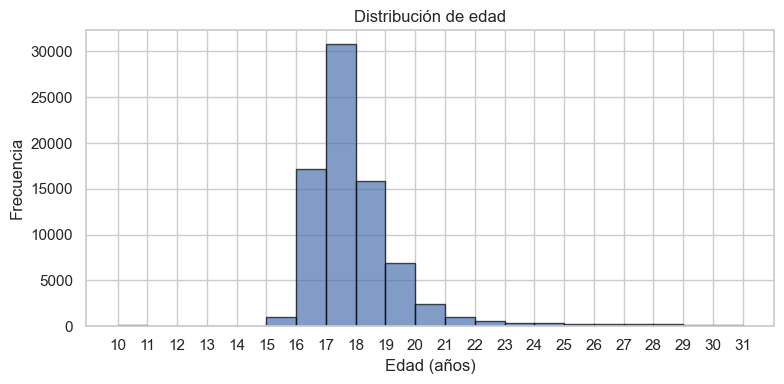

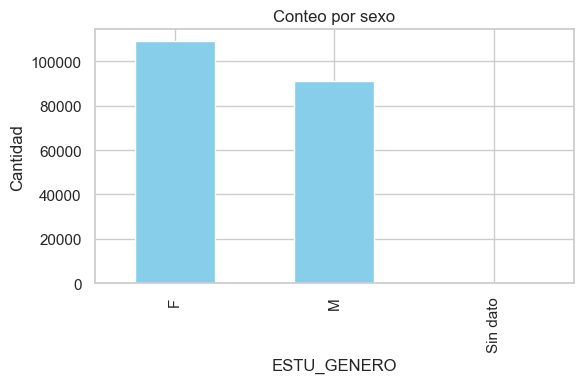

estrato_num
1.0    238.5
2.0    254.5
3.0    268.4
4.0    285.2
5.0    293.5
6.0    305.4
Name: PUNT_GLOBAL, dtype: float64


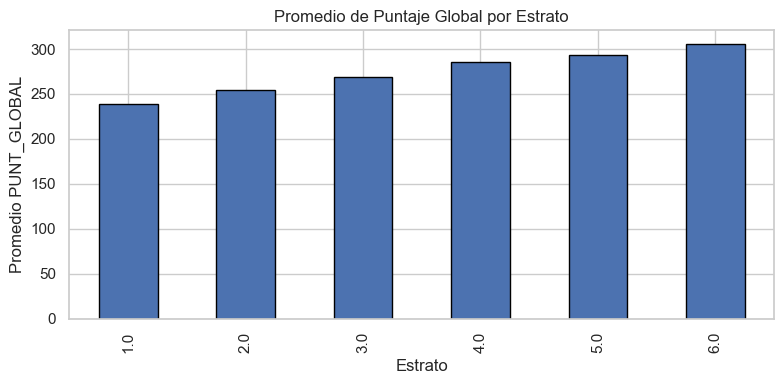

ESTU_DEPTO_PRESENTACION
BOGOTÁ             273.6
SANTANDER          265.4
BOYACA             263.4
NORTE SANTANDER    258.0
CUNDINAMARCA       257.6
RISARALDA          257.4
VALLE              255.3
QUINDIO            255.0
META               254.1
CALDAS             253.4
Name: PUNT_GLOBAL, dtype: float64


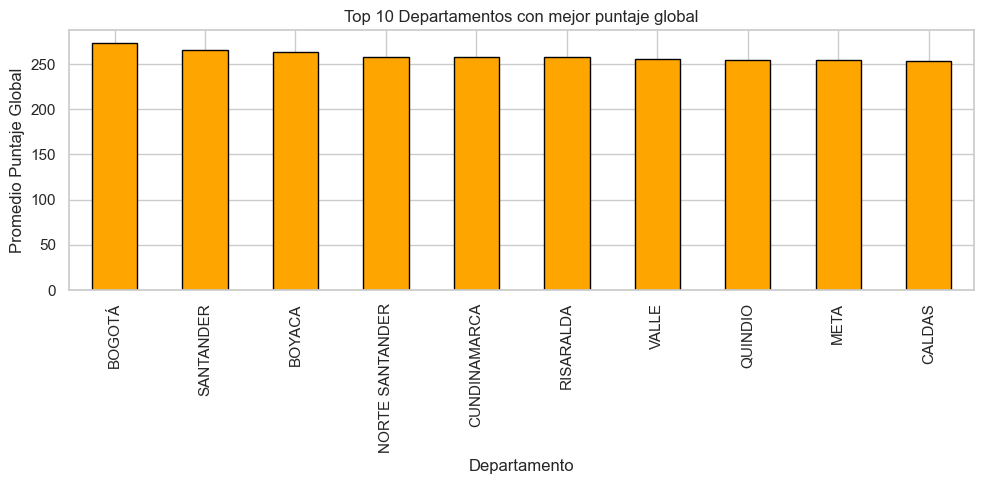

                         PUNT_INGLES  PUNT_MATEMATICAS  \
ESTU_DEPTO_PRESENTACION                                  
AMAZONAS                        44.4              42.5   
ANTIOQUIA                       47.8              48.1   
ARAUCA                          45.9              48.7   
ATLANTICO                       48.7              48.3   
BOGOTÁ                          53.6              53.2   

                         PUNT_SOCIALES_CIUDADANAS  PUNT_C_NATURALES  \
ESTU_DEPTO_PRESENTACION                                               
AMAZONAS                                     42.0              43.6   
ANTIOQUIA                                    48.3              48.5   
ARAUCA                                       47.1              48.9   
ATLANTICO                                    47.6              49.1   
BOGOTÁ                                       53.3              54.2   

                         PUNT_LECTURA_CRITICA  
ESTU_DEPTO_PRESENTACION                        

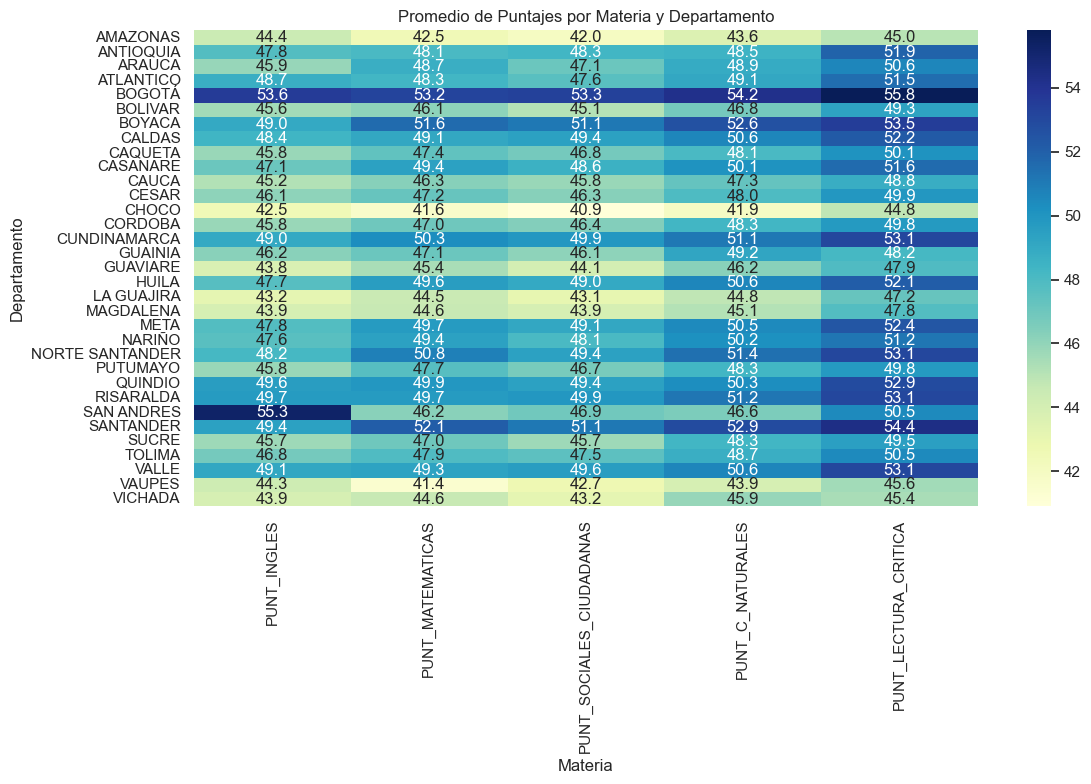

Columna FAMI_TIENEINTERNET, FAMI_TIENE_COMPUTADOR no encontrada. Omitiendo.


In [ ]:

os.makedirs("outputs", exist_ok=True)

DATA_CSV = "Saber11.csv"

usecols = [
    'PERIODO','ESTU_FECHANACIMIENTO','ESTU_GENERO','FAMI_ESTRATOVIVIENDA',
    'ESTU_DEPTO_PRESENTACION','COLE_NOMBRE_ESTABLECIMIENTO',
    'PUNT_INGLES','PUNT_MATEMATICAS','PUNT_SOCIALES_CIUDADANAS',
    'PUNT_C_NATURALES','PUNT_LECTURA_CRITICA','PUNT_GLOBAL','DESEMP_INGLES', 'ESTU_DEPTO_RESIDE',
    'FAMI_TIENEINTERNET', 'FAMI_TIENE_COMPUTADOR'
]

df_full = pd.read_csv(DATA_CSV, low_memory=False)
print("Datos cargados:", df_full.shape)

df = df_full.sample(200000, random_state=42)
print("Muestra:", df.shape)

df['ESTU_FECHANACIMIENTO'] = pd.to_datetime(df['ESTU_FECHANACIMIENTO'], errors='coerce')
df['anio_nac'] = df['ESTU_FECHANACIMIENTO'].dt.year

df['anio_exam'] = df['PERIODO'].astype(str).str[:4].astype(float)
df['edad'] = df['anio_exam'] - df['anio_nac']

df.loc[(df['edad'] < 10) | (df['edad'] > 30), 'edad'] = None

print(df[['PERIODO','ESTU_FECHANACIMIENTO','anio_nac','anio_exam','edad']].head())

plt.figure(figsize=(8,4))
edades = df['edad'].dropna().astype(int)
bins = range(int(edades.min()), int(edades.max())+2)
plt.hist(edades, bins=bins, edgecolor='black', alpha=0.7)
plt.title('Distribución de edad')
plt.xlabel('Edad (años)')
plt.ylabel('Frecuencia')
plt.xticks(bins)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
df['ESTU_GENERO'].fillna('Sin dato').value_counts().plot(kind='bar', color='skyblue')
plt.title('Conteo por sexo')
plt.ylabel('Cantidad')
plt.tight_layout()
plt.show()

df['estrato_num'] = (
    df['FAMI_ESTRATOVIVIENDA']
    .astype(str)
    .str.extract(r'(\d+)')   # saca el número
    .astype(float)
)

tabla_estrato = df.groupby('estrato_num')['PUNT_GLOBAL'].mean().dropna().round(1)
print(tabla_estrato)

plt.figure(figsize=(8,4))
tabla_estrato.plot(kind='bar', edgecolor='black')
plt.title('Promedio de Puntaje Global por Estrato')
plt.ylabel('Promedio PUNT_GLOBAL')
plt.xlabel('Estrato')
plt.tight_layout()
plt.show()

tabla_estrato.to_csv('outputs/promedio_por_estrato.csv')

tabla_deptos = df.groupby('ESTU_DEPTO_PRESENTACION')['PUNT_GLOBAL'].mean().dropna().round(1)
top_deptos = tabla_deptos.sort_values(ascending=False).head(10)
print(top_deptos)

plt.figure(figsize=(10,5))
top_deptos.plot(kind='bar', color='orange', edgecolor='black')
plt.title('Top 10 Departamentos con mejor puntaje global')
plt.ylabel('Promedio Puntaje Global')
plt.xlabel('Departamento')
plt.tight_layout()
plt.show()

tabla_deptos.to_csv('outputs/promedio_por_departamento.csv')

materias = ['PUNT_INGLES','PUNT_MATEMATICAS','PUNT_SOCIALES_CIUDADANAS',
            'PUNT_C_NATURALES','PUNT_LECTURA_CRITICA']

df[materias] = df[materias].apply(pd.to_numeric, errors='coerce')

materias_por_depto = df.groupby('ESTU_DEPTO_PRESENTACION')[materias].mean().round(1)

print(materias_por_depto.head())

plt.figure(figsize=(12,8))
sns.heatmap(materias_por_depto, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title('Promedio de Puntajes por Materia y Departamento')
plt.ylabel('Departamento')
plt.xlabel('Materia')
plt.tight_layout()
plt.show()

materias_por_depto.to_csv('outputs/promedio_por_materia.csv')

fami_vars = ['FAMI_TIENEINTERNET']

for var in fami_vars:
    if var not in df.columns:
        print(f"Columna {var} no encontrada. Omitiendo.")
        continue

    s = df[var].astype(str).str.strip().str.lower()

    s = s.replace({'sí': 'si', 'si': 'si', 's': 'si', '1': 'si','no': 'no', 'n': 'no', '0': 'no'})

    s = s.where(s.isin(['si', 'no']))

    counts = s.value_counts().reindex(['si','no']).fillna(0)

    plt.figure(figsize=(5,3))
    counts.index = counts.index.str.capitalize()
    counts.plot(kind='bar', edgecolor='black', color=['#2ca02c','#d62728'])
    plt.title(f'Distribución de {var}')
    plt.ylabel('Cantidad')
    plt.xlabel(var)
    plt.show()

**Fase 2**

Estadísticas descriptivas de puntajes:

                                mean  median    std_dev
PUNT_GLOBAL               252.444832   249.0  50.563132
PUNT_INGLES                48.590111    46.0  12.218970
PUNT_MATEMATICAS           49.318995    49.0  11.938801
PUNT_SOCIALES_CIUDADANAS   48.906635    49.0  11.735413
PUNT_C_NATURALES           50.132297    50.0  10.584670
PUNT_LECTURA_CRITICA       52.202396    52.0  10.420510

Distribución de FAMI_ESTRATOVIVIENDA:
FAMI_ESTRATOVIVIENDA
Estrato 1      70359
Estrato 2      68461
Estrato 3      37682
Estrato 4       9201
NaN             6170
Estrato 5       3487
Sin Estrato     2531
Estrato 6       2109
Name: count, dtype: int64

Distribución de ESTU_GENERO:
ESTU_GENERO
F      108914
M       90999
NaN        87
Name: count, dtype: int64

Distribución de FAMI_TIENEINTERNET:
FAMI_TIENEINTERNET
Si     104773
No      89891
NaN      5336
Name: count, dtype: int64


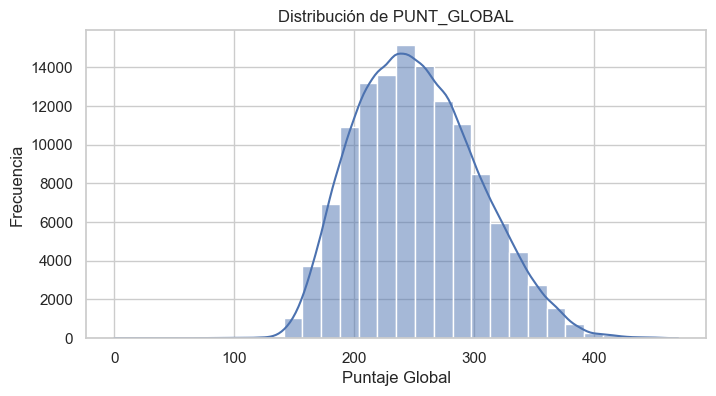

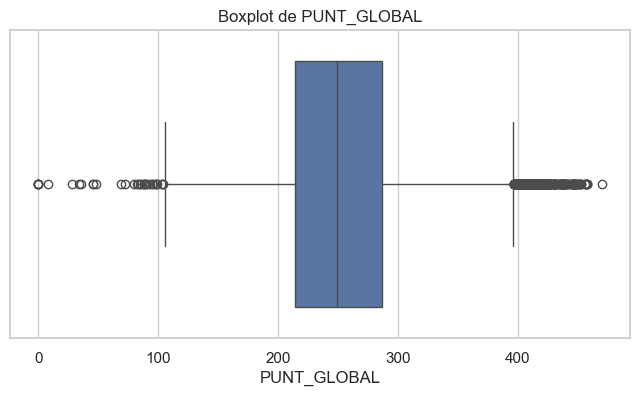

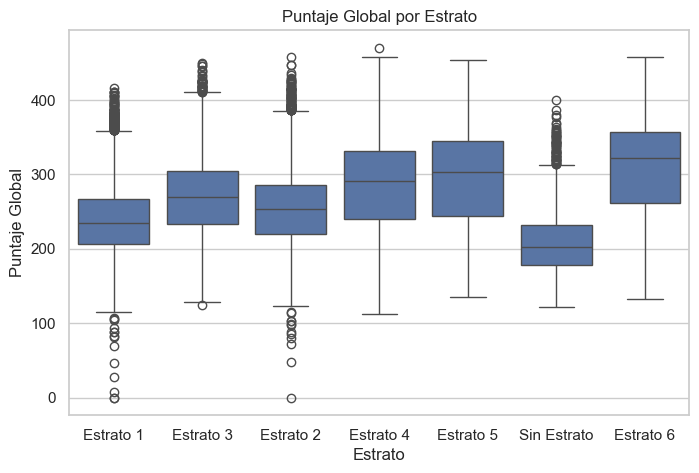

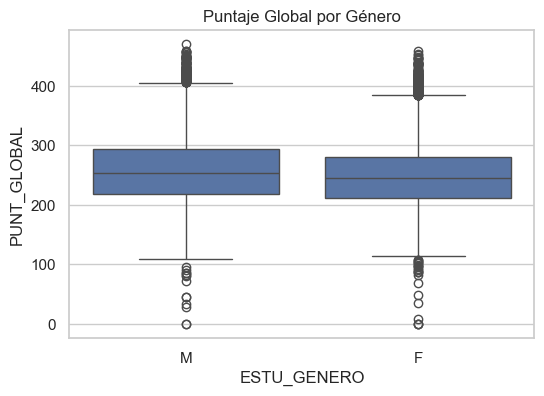

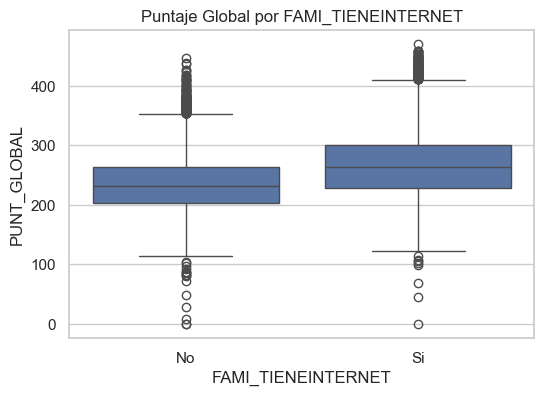

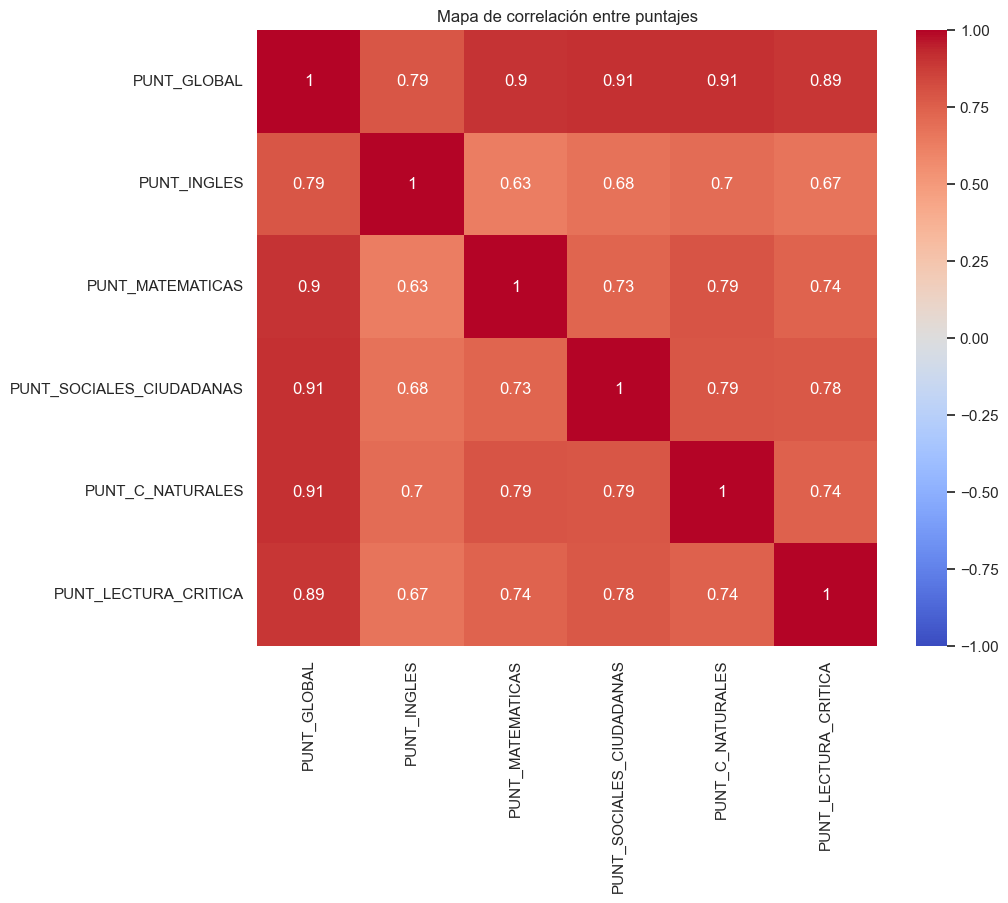


Promedio de Puntaje Global por Estrato y Género:

ESTU_GENERO                    F           M
FAMI_ESTRATOVIVIENDA                        
Estrato 1             235.314207  242.897700
Estrato 2             251.028691  258.612501
Estrato 3             265.420960  271.523801
Estrato 4             286.010403  284.459866
Estrato 5             294.019126  293.010949
Estrato 6             301.314759  309.242165
Sin Estrato           208.107822  211.687050


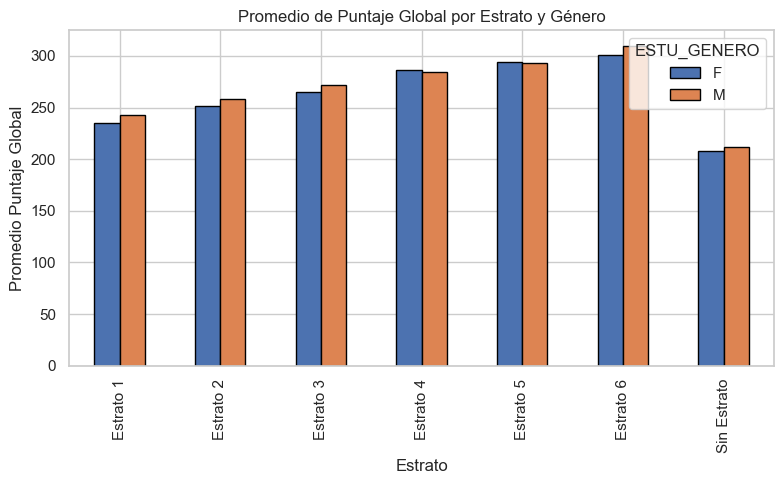

In [ ]:

df.columns = df.columns.str.strip().str.upper()

variables_num = ['PUNT_GLOBAL', 'PUNT_INGLES', 'PUNT_MATEMATICAS',
'PUNT_SOCIALES_CIUDADANAS', 'PUNT_C_NATURALES', 'PUNT_LECTURA_CRITICA']

variables_cat = ['FAMI_ESTRATOVIVIENDA', 'ESTU_GENERO', 'FAMI_TIENEINTERNET']

desc_num = df[variables_num].describe().T[['mean', '50%', 'std']]
desc_num.rename(columns={'50%':'median', 'std':'std_dev'}, inplace=True)
print("Estadísticas descriptivas de puntajes:\n")
print(desc_num)

for var in variables_cat:
    if var in df.columns:
        print(f"\nDistribución de {var}:")
        print(df[var].value_counts(dropna=False))

plt.figure(figsize=(8,4))
sns.histplot(df['PUNT_GLOBAL'], bins=30, kde=True)
plt.title("Distribución de PUNT_GLOBAL")
plt.xlabel("Puntaje Global")
plt.ylabel("Frecuencia")
plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(x='PUNT_GLOBAL', data=df)
plt.title("Boxplot de PUNT_GLOBAL")
plt.show()

if 'FAMI_ESTRATOVIVIENDA' in df.columns:
    plt.figure(figsize=(8,5))
    sns.boxplot(x='FAMI_ESTRATOVIVIENDA', y='PUNT_GLOBAL', data=df)
    plt.title("Puntaje Global por Estrato")
    plt.xlabel("Estrato")
    plt.ylabel("Puntaje Global")
    plt.show()

if 'ESTU_GENERO' in df.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='ESTU_GENERO', y='PUNT_GLOBAL', data=df)
    plt.title("Puntaje Global por Género")
    plt.show()

for var in ['FAMI_TIENEINTERNET']:
    if var in df.columns:
        plt.figure(figsize=(6,4))
        sns.boxplot(x=var, y='PUNT_GLOBAL', data=df)
        plt.title(f"Puntaje Global por {var}")
        plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(df[variables_num].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Mapa de correlación entre puntajes")
plt.show()

if 'FAMI_ESTRATOVIVIENDA' in df.columns and 'ESTU_GENERO' in df.columns:
    tabla_group = df.groupby(['FAMI_ESTRATOVIVIENDA','ESTU_GENERO'])['PUNT_GLOBAL'].mean().unstack()
    print("\nPromedio de Puntaje Global por Estrato y Género:\n")
    print(tabla_group)

    tabla_group.plot(kind='bar', figsize=(8,5), edgecolor='black')
    plt.title("Promedio de Puntaje Global por Estrato y Género")
    plt.ylabel("Promedio Puntaje Global")
    plt.xlabel("Estrato")
    plt.tight_layout()
    plt.show()

**Fase 3**

Modelo entrenado sin NaN en y ✔️
Resultados Regresión Lineal:
R²: 0.172
RMSE: 45.91

📊 Resultados Regresión Logística:
Accuracy: 0.638

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.65      0.60      0.62     18796
           1       0.63      0.68      0.65     19139

    accuracy                           0.64     37935
   macro avg       0.64      0.64      0.64     37935
weighted avg       0.64      0.64      0.64     37935



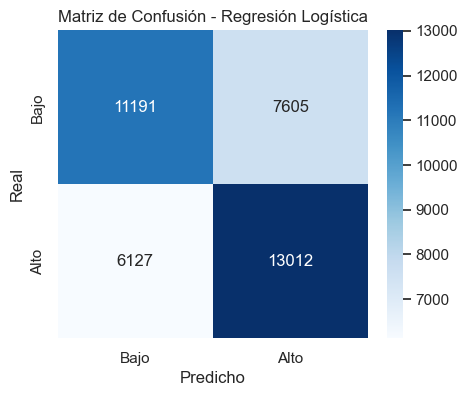

In [ ]:

df.columns = df.columns.str.strip().str.upper()

df_model = df.dropna(subset=['PUNT_GLOBAL']).copy()

y = df_model['PUNT_GLOBAL']

X = df_model[['FAMI_ESTRATOVIVIENDA','ESTU_GENERO','FAMI_TIENEINTERNET',
'FAMI_TIENECOMPUTADOR','FAMI_TIENEAUTOMOVIL']].copy()

X = pd.get_dummies(X, drop_first=True)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

print("Modelo entrenado sin NaN en y ✔️")

y_pred = lin_reg.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Resultados Regresión Lineal:")
print(f"R²: {r2:.3f}")
print(f"RMSE: {rmse:.2f}")

umbral = y.median()
y_binaria = (y >= umbral).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y_binaria, test_size=0.3, random_state=42)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

y_pred_class = log_reg.predict(X_test)

acc = accuracy_score(y_test, y_pred_class)
print("\n📊 Resultados Regresión Logística:")
print(f"Accuracy: {acc:.3f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_class))

cm = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Bajo','Alto'], yticklabels=['Bajo','Alto'])
plt.title("Matriz de Confusión - Regresión Logística")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()
